In [1]:
from unittest.mock import inplace
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import ssl
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer, util
import torch

In [2]:
# Bypass SSL certificate verification
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sowrabharavishankar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sowrabharavishankar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sowrabharavishankar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
column_names = ['Uniq Id', 'timestamp', 'Asin', 'title', 'Image URL', 'weight', 'description', 'price', 'Reviews', 'Buybox winner', 'other seller', 'other seller Price', 'other seller_2', 'other seller 2 price', 'misc', 'Category', 'Availability']
df = pd.read_csv("product_details_amazon.csv", header=0, names=column_names)
df = df.reset_index(drop=True)

In [4]:
#Delete unnecessary columns
df.drop(['Buybox winner', 'other seller', 'other seller Price', 'other seller_2', 'other seller 2 price', 'misc', 'price', 'weight'], axis = 1, inplace=True)

In [5]:
# Impute text columns (description, title, brand, category)
text_columns = ['title', 'description', 'Reviews', 'Category', 'Availability', 'Image URL']
for col in text_columns:
    df[col] = df[col].fillna("No description")

#### **Visualization**

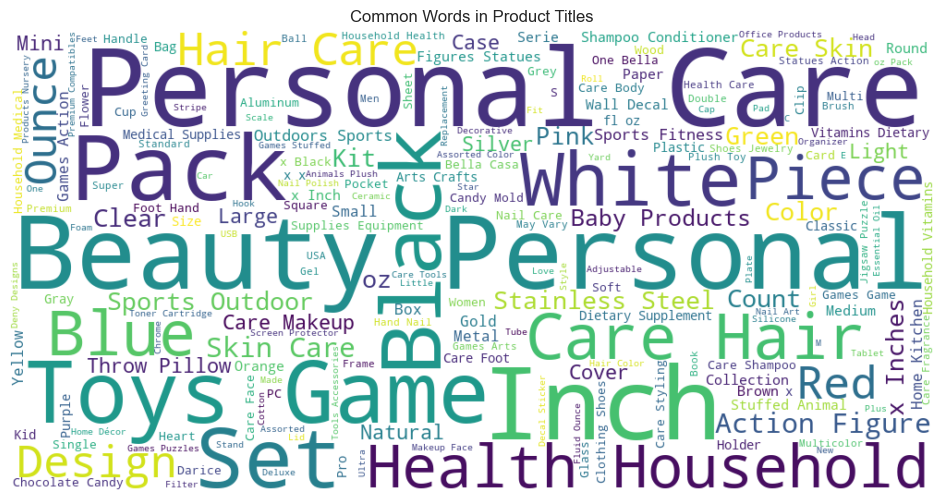

In [6]:
text = " ".join(df['title'].dropna().astype(str).tolist())
wc = WordCloud(width=1000, height=500, background_color="white").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Common Words in Product Titles")
plt.show()

## **Text Processing**

In [7]:
stop_words = set(stopwords.words('english'))

def preprocessing_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

df['Cleaned_reviews'] = df['Reviews'].apply(preprocessing_text)

#### **TF-IDF & Cosine Similarity**

In [8]:
#combine textual features
df['text'] = (
    df['title'].fillna('') + ' ' +
    df['Category'].fillna('') + ' ' +
    df['description'].fillna('')
)

In [9]:
# TF-IDF vectorization
print("⚙️  Building TF-IDF matrix...")
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
tfidf_matrix = vectorizer.fit_transform(df['text'])
print("TF-IDF matrix shape:", tfidf_matrix.shape)

⚙️  Building TF-IDF matrix...
TF-IDF matrix shape: (30000, 10000)


In [10]:
#Compute cosine similarity
print("📏 Calculating cosine similarity...")
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("Similarity matrix ready!")

📏 Calculating cosine similarity...
Similarity matrix ready!


In [11]:
#Define recommendation function - content based
def recommend(product_title, top_n=5):
    idx = df[df['title'].str.contains(product_title, case=False, na=False)].index
    if len(idx) == 0:
        print("❌ No product found matching that title.")
        return None

    idx = idx[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_indices = [i for i, _ in sim_scores[1:top_n+1]]

    results = df.iloc[top_indices][['title', 'Category', 'description']].copy()
    results['similarity_score'] = [sim_scores[i+1][1] for i in range(top_n)]
    return results.reset_index(drop=True)

In [12]:
content = "headphones"
recommendations = recommend(content, top_n=5)
print(f"\n Top recommendations for '{content}':")
display(recommendations)


 Top recommendations for 'headphones':


,title,Category,description,similarity_score
0,eBoot 3.5 mm Speaker and Headphone Splitter C...,Electronics Accessories & Supplies Audio & Vi...,No description,0.328981
1,Hermitshell Travel Case Fits Sennheiser HD 20...,Electronics Accessories & Supplies Audio & Vi...,No description,0.318756
2,"White Replacement Earpads, AGPtEK 2 Pieces Fo...",Electronics Accessories & Supplies Audio & Vi...,No description,0.294099
3,Poly-Planar WC-3 Face Cover Hardware Mount,Electronics › Portable Audio & Video › MP3 & ...,"Marine Stereo Splash Cover, Poly-Planar Part N...",0.282229
4,Catalyst Airpods Case Protective Silicon Cove...,Electronics Accessories & Supplies Audio & Vi...,No description,0.280203


#### **SBERT Model**

In [13]:
# Combine columns for embeddings
df['combined_text'] = df['title'] + " " + df['description'] + " " + df['Category']

# Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode all product descriptions
product_embeddings = model.encode(df['combined_text'].tolist(), convert_to_tensor=True)

# Function to get top-N recommendations based on a search query
def search_recommendations(query, top_n=3):
    # Encode the search query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Compute cosine similarity with all products
    similarities = util.cos_sim(query_embedding, product_embeddings)[0]

    # Get top N indices
    top_indices = torch.topk(similarities, k=top_n).indices.tolist()

    # Return top-N products with similarity scores
    return df.iloc[top_indices][['Uniq Id', 'title', 'Category', 'description']].assign(
        similarity=[float(similarities[i]) for i in top_indices]
    )


In [14]:
# search query
query = "muesli"
top_products = search_recommendations(query, top_n=5)
print(f"\n Top recommendations for '{top_products}':")


 Top recommendations for '                                Uniq Id  \
24690  74e7ede9b39c47876523a65876245e39   
16930  1dc5fbb64f08f9f4e7ff1226244fcef4   
15163  7fb24080f50a0b0539381d8517ade860   
275    1876cbeb5067cca567dd8b9508c89af3   
21478  831cd4c8be25200e37794d4a41c7d15f   

                                                   title  \
24690   MUJI Japan ★2015 Autumn Latest ver.★ Facial C...   
16930   Loloi Loloi-DSETP0242RUMLPIL3-Rust/Multi Deco...   
15163   The Face Shop Herb Day Cleansing Cleansing Fo...   
275     Body Fantasies Fresh White Musk 3 Piece Gift ...   
21478                Mary Meyer Mulligan Moose Soft Toy    

                                                Category  \
24690   Beauty & Personal Care Tools & Accessories Co...   
16930   Home & Kitchen › Bedding › Decorative Pillows...   
15163   Beauty & Personal Care Skin Care Face Cleanse...   
275       Beauty & Personal Care Fragrance Women's Sets    
21478       Toys & Games › Stuffed Animals & Plush To

#### **SBERT Model - all-MiniLM-L12-v2**

In [15]:
# Load a more accurate SBERT model
model = SentenceTransformer('all-MiniLM-L12-v2')

#Encode each column separately
title_embeddings = model.encode(df['title'].tolist(), convert_to_tensor=True)
desc_embeddings = model.encode(df['description'].tolist(), convert_to_tensor=True)
category_embeddings = model.encode(df['Category'].tolist(), convert_to_tensor=True)

# Combine embeddings with weights: title=0.5, description=0.4, category=0.1
product_embeddings = 0.5*title_embeddings + 0.4*desc_embeddings + 0.1*category_embeddings

# Function to get top-N recommendations for a search query
def search_recommendations(query, top_n=3):
    # Encode the search query with the same weighted approach
    query_title_emb = model.encode(query, convert_to_tensor=True)
    query_embedding = query_title_emb  # For a query, we can treat it like title

    # Compute cosine similarity
    similarities = util.cos_sim(query_embedding, product_embeddings)[0]

    # Get top N indices
    top_indices = torch.topk(similarities, k=top_n).indices.tolist()

    # Return top-N products with similarity scores
    return df.iloc[top_indices][['Uniq Id', 'title', 'description', 'Category']].assign(
        similarity=[float(similarities[i]) for i in top_indices]
    )


In [16]:
# Example search query
query = "soil"
top_products = search_recommendations(query, top_n=3)
print(f"\n Top recommendations for '{top_products}':")


 Top recommendations for '                                Uniq Id  \
9984   e14478434642923ccb3762f747a65274   
10641  b73b9d243f21718d7977ef1bbd9028da   
686    46ec29df92cf7c1dd2a0320ba828b7a2   

                                                   title  \
9984    Luster Leaf 1818 Rapitest 4-in1 Soil pH/Moist...   
10641   Starwest Botanicals Fuller's Earth Powder, 1 ...   
686     Bloem 20-56108 Fiskars 8 Inch Ariana with Sel...   

                                             description  \
9984                                      No description   
10641  1 lb of Fuller's Earth Powder, packaged in a r...   
686                                       No description   

                                                Category  similarity  
9984    Patio, Lawn & Garden › Gardening & Lawn Care ...    0.526829  
10641                                     No description    0.466417  
686     Patio, Lawn & Garden Gardening & Lawn Care Po...    0.425222  ':


In [17]:
# Load the search-optimized model
model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1')

# Encode each column separately
title_embeddings = model.encode(df['title'].tolist(), convert_to_tensor=True)
desc_embeddings = model.encode(df['description'].tolist(), convert_to_tensor=True)
category_embeddings = model.encode(df['Category'].tolist(), convert_to_tensor=True)

# Weighted combination of embeddings: title=0.5, description=0.4, category=0.1
product_embeddings = 0.5*title_embeddings + 0.4*desc_embeddings + 0.1*category_embeddings

# Function to get top-N recommendations based on a search query
def search_recommendations(query, top_n=3):
    # Encode the search query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # Compute cosine similarity with product embeddings
    similarities = util.cos_sim(query_embedding, product_embeddings)[0]

    # Get top N indices
    top_indices = torch.topk(similarities, k=top_n).indices.tolist()

    # Return top-N products with similarity scores
    return df.iloc[top_indices][['Uniq Id', 'title', 'description', 'Category']].assign(
        similarity=[float(similarities[i]) for i in top_indices]
    )

In [18]:
query = "headphones"
top_products = search_recommendations(query, top_n=5)
print(f"\n Top recommendations for '{top_products}':")


 Top recommendations for '                                Uniq Id  \
19629  86d1a857bf6306b3709682329b2491b1   
3934   5b66e65b93a5e3524ca146b612bbf3ae   
18233  0b15cc33d5bf8c92ef01a5b6a203fbd0   
28261  457239c531da149da2d1f3a8839f88c7   
19995  1093dba1507da58f0a2c692c38e326c5   

                                                   title  \
19629   Sports & Outdoors Fan Shop Electronics Headph...   
3934    SADES SA-708 Professional 3.5mm Stereo Headse...   
18233                     Neonz Slimz Headphones- 11449    
28261          AKG K 240 MK II Stereo Studio Headphones    
19995   Headphones w/ Mircophone Boom by Cellet | Aud...   

                                             description  \
19629   NFL Baltimore Ravens iHip Ear Buds with Micro...   
3934   Ideal Headphones to Enjoy Music and Internet C...   
18233                                     No description   
28261                                     No description   
19995                                     No descript

## **Visualization**

In [19]:
top_products.style.background_gradient(subset=['similarity'], cmap='Greens')

,Uniq Id,title,description,Category,similarity
19629,86d1a857bf6306b3709682329b2491b1,Sports & Outdoors Fan Shop Electronics Headphones,NFL Baltimore Ravens iHip Ear Buds with Microphone,No description,0.764171
3934,5b66e65b93a5e3524ca146b612bbf3ae,SADES SA-708 Professional 3.5mm Stereo Headset Headband PC Notebook Pro Gaming Headphone - Black/Blue,"Ideal Headphones to Enjoy Music and Internet Chat (Skype, MSN, Google Talk, etc.).Built-in Microphone can be swiveled and bent to fit your need, and in-line adjustable volume control.Low power consumption, plug and play, no PC driver required. Sensitivity: 105 dB SPL at 1kHz. Headphone Impedance: 32 Ohm. Frequency Response: 20Hz-20,000Hz. 5.5 Ft (66 inch) Heavy Duty Cable Length. High quality,100% brand new.Compatibility: All computers, laptops and mp3 players with 3.5 mm male jack support. Package Includes: 1 set of headphone with microphone. Color: Black / Red",Electronics Computers & Accessories Computer Accessories & Peripherals Audio & Video Accessories Computer Headsets,0.723285
18233,0b15cc33d5bf8c92ef01a5b6a203fbd0,Neonz Slimz Headphones- 11449,No description,Electronics Headphones On-Ear Headphones,0.704052
28261,457239c531da149da2d1f3a8839f88c7,AKG K 240 MK II Stereo Studio Headphones,No description,Musical Instruments › Studio Recording Equipment › Headphone & In-Ear Audio Monitors › Headphones,0.695682
19995,1093dba1507da58f0a2c692c38e326c5,"Headphones w/ Mircophone Boom by Cellet | Audio Headphones fo computer, Headset w/ Mircophone, Ajustable Headset w/ Mircophone | 2.5mm",No description,Electronics Headphones Over-Ear Headphones,0.693151


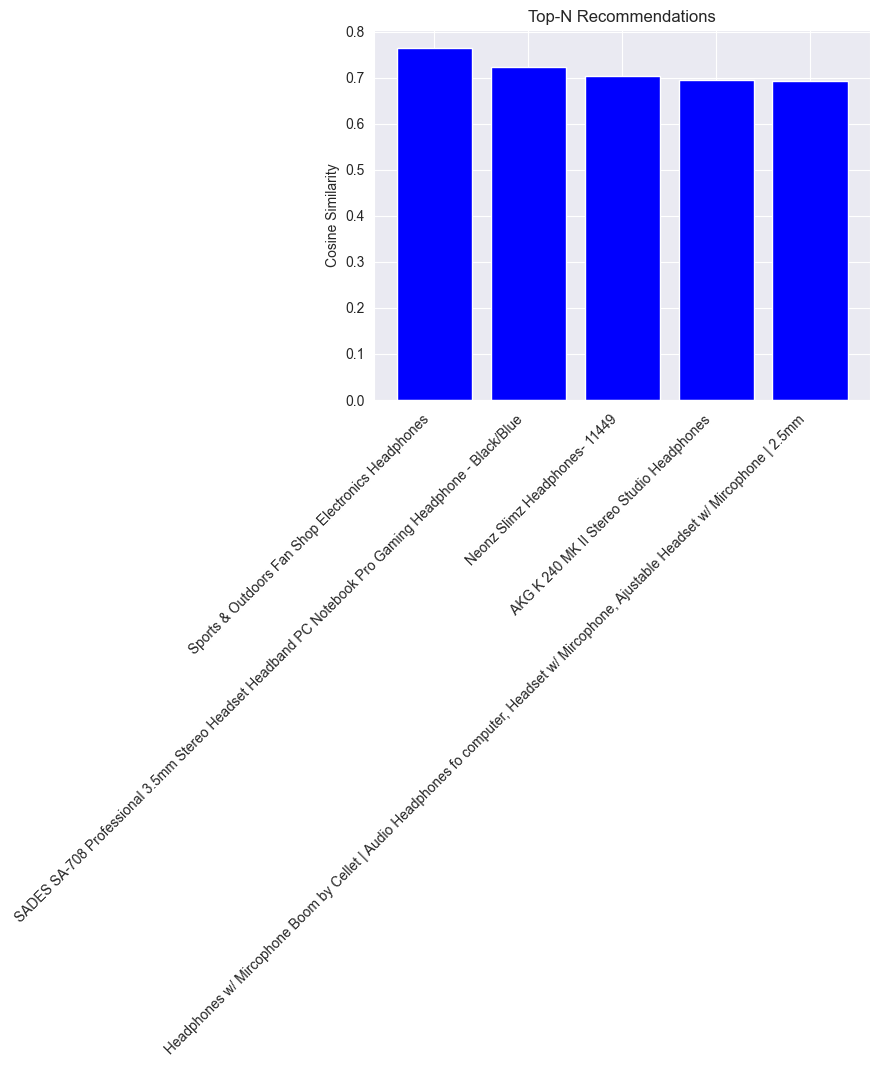

In [20]:
plt.bar(top_products['title'], top_products['similarity'], color='blue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Cosine Similarity')
plt.title('Top-N Recommendations')
plt.show()